In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
sns.set()

In [2]:
crm = pd.read_csv('Sample GB Диплом Веб-аналитика - CRM.csv', parse_dates=['Order Date', 'Ship Date'], dayfirst=True)
sessions = pd.read_csv('Sample GB Диплом Веб-аналитика - sessions.csv', parse_dates=['SessionDate'], dayfirst=True)
costs = pd.read_csv('Sample GB Диплом Веб-аналитика - costs.csv', parse_dates=['Date'], dayfirst=True)

In [3]:
costs = pd.melt(costs, id_vars = ['Date', 'campaign'], 
        value_vars=['google / cpc', 'yandex / cpc', 'vkontakte / cpc']) \
        .rename(columns={'variable':'source / medium', 'value':'cost'})
costs.head()

,Date,campaign,source / medium,cost
0,2011-01-01,brand,google / cpc,387
1,2011-01-01,not_brand,google / cpc,0
2,2011-01-02,not_brand,google / cpc,459
3,2011-01-02,brand,google / cpc,229
4,2011-01-03,not_brand,google / cpc,66


In [4]:
def change_name(name):
    return name.replace(' / ', '_').replace(' ', '_').replace('-', '_').lower()
    
crm = crm.rename(columns=change_name)
sessions = sessions.rename(columns=change_name)
costs = costs.rename(columns=change_name)

In [5]:
crm.head()

,client_id,order_id,order_date,order_quantity,sales,discount,ship_mode,profit,unit_price,shipping_cost,region,product_category,product_sub_category,product_name,ship_date
0,2b97454da406955ec40c097647e38316,130,2011-05-07,3,"461,89","0,05",Express,"-309,82","150,98","13,99",Saint-Petersburg,Technology,Office Machines,Canon MP41DH Printing Calculator,2012-05-09
1,2b97454da406955ec40c097647e38316,130,2011-05-07,29,"575,11","0,02",Express,"71,75","18,97","9,03",Saint-Petersburg,Office Supplies,Paper,Computer Printout Paper with Letter-Trim Perfo...,2012-05-08
2,2b97454da406955ec40c097647e38316,130,2011-05-07,23,"236,46","0,05",Express,"-134,31","9,71","9,45",Saint-Petersburg,Office Supplies,Storage & Organization,Filing/Storage Totes and Swivel Casters,2012-05-10
3,59ca19169a2d00aa2466bb9c518a99e7,166,2011-09-11,10,"567,936","0,02",Express,"-126,09","65,99","8,99",Moscow,Technology,Telephones and Communication,i270,2011-09-13
4,19d90e0481d1d33e94c2bd99e7d4b3fd,416,2011-09-26,20,"1156,6715","0,01",Express,"88,52","65,99","7,69",Moscow,Technology,Telephones and Communication,5190,2010-10-01


In [6]:
sessions.info()
sessions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19080 entries, 0 to 19079
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   client_id      19080 non-null  object        
 1   sessiondate    19080 non-null  datetime64[ns]
 2   order_id       4723 non-null   float64       
 3   transaction    18107 non-null  float64       
 4   source_medium  19080 non-null  object        
 5   campaign       8543 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 894.5+ KB


,client_id,sessiondate,order_id,transaction,source_medium,campaign
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-14,NaN,0.0,sendpulse / email,news
1,00039fbdd03f38f626f9b1762e10b31a,2011-04-17,NaN,0.0,direct,NaN
2,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117.0,1.0,direct,NaN
3,00039fbdd03f38f626f9b1762e10b31a,2011-06-05,NaN,0.0,mail / organic,NaN
4,00039fbdd03f38f626f9b1762e10b31a,2011-06-08,NaN,0.0,yandex / cpc,brand


In [7]:
# в transaction есть nan, но sessions.transaction.sum() = 4723 - совпадает с кол-вом order_id, заменим их на 0
sessions.transaction = sessions.transaction.fillna(0)

In [8]:
# проверим также есть ли дубли среди order_id
sessions.order_id.dropna().astype(str).describe()

count        4723
unique       4723
top       12902.0
freq            1
Name: order_id, dtype: object

In [9]:
#заодно проверим что с order_id в таблице из crm
crm.order_id.dropna().astype(str).describe()

count      7220
unique     4723
top       43745
freq          6
Name: order_id, dtype: object

In [10]:
costs.head()

,date,campaign,source_medium,cost
0,2011-01-01,brand,google / cpc,387
1,2011-01-01,not_brand,google / cpc,0
2,2011-01-02,not_brand,google / cpc,459
3,2011-01-02,brand,google / cpc,229
4,2011-01-03,not_brand,google / cpc,66


## Начальный уровень

#### 1) В каком полугодии расходы по Вконтакте больше?

In [11]:
print(costs.date.min())
print(costs.date.max())

2011-01-01 00:00:00
2011-12-31 00:00:00


In [12]:
vk = "vkontakte / cpc"
july_1 = "2011-07-01"

is_first_more = costs.query('source_medium == @vk and date < @july_1').cost.sum() > \
            costs.query('source_medium == @vk and date >= @july_1').cost.sum()

if is_first_more == True:
    print('Расходы в первом полугодии больше, чем во втором')
else:
    print('Расходы во втором полугодии больше, чем в первом')

Расходы во втором полугодии больше, чем в первом


#### 2) Рассчитайте расход без учёта НДС в рамках не брендовых рекламных кампаний за Q2

In [13]:
april_1 = "2011-04-01"
a2 = round(costs.query('campaign == "not_brand" and date >= @april_1 and date<@july_1').cost.sum() / 1.2, 1)

print(f'{a2} - расход без НДС')

67671.7 - расход без НДС


#### 3) Рассчитайте среднее количество рекламных кликов за день за год

In [14]:
sessions.source_medium.unique()

array(['sendpulse / email', 'direct', 'mail / organic', 'yandex / cpc',
       'google / cpc', 'yandex / organic', 'google / organic',
       'vkontakte / cpc'], dtype=object)

In [15]:
a3 = round(sessions.query('source_medium.str.contains(" / cp")', engine='python').shape[0] / sessions.sessiondate.nunique(), 1)

print(f'{a3} - среднее количество рекламных кликов')

18.0 - среднее количество рекламных кликов


#### 4) Рассчитайте количество уникальных пользователей, посетивших сайт за год

In [16]:
print(f'{sessions.client_id.nunique()} - уникальных пользователей за год')

1567 - уникальных пользователей за год


#### 5) Рассчитайте общее количество заказов за год

In [17]:
print( f'{sessions.transaction.sum()} - количество заказов за год')

4723.0 - количество заказов за год


## Средний уровень

#### 6) Определите лимит на расход в день для рекламы Вконтакте

In [18]:
costs.query('source_medium == @vk')\
    .groupby(['date', 'campaign']).agg({'cost':'sum'}).sort_values('cost', ascending=False).reset_index().head()

,date,campaign,cost
0,2011-08-14,brand,992
1,2011-02-25,not_brand,991
2,2011-10-28,brand,981
3,2011-03-12,not_brand,977
4,2011-04-18,brand,975


In [19]:
# Лимит 1000

#### 7) Определите, в какой день была самая высокая конверсия на сайте

In [20]:
sessions7 = sessions.groupby(['sessiondate']).agg({'client_id':'count', 'transaction':'sum'})
sessions7['CR'] = sessions7.transaction / sessions7.client_id

date_max_cr = datetime.strftime(sessions7.CR.idxmax(), '%d-%m-%y')
print(f'{date_max_cr} - день с самой высокой конверсией')

19-09-11 - день с самой высокой конверсией


#### 8) Рассчитайте средний LTV за год по всем клиентам

In [21]:
crm.profit = crm.profit.apply(lambda x: x.replace(',', '.')).astype(float)
a8 = crm.groupby(['client_id'], as_index=False).agg({'profit':'sum'}).profit.median()
print(f'{a8} - средний LTV')

725.58 - средний LTV


#### 9) Рассчитайте среднюю конверсию для каждого из рекламных каналов

In [22]:
sessions9 = sessions.copy()
sessions9['month'] = sessions9.sessiondate.dt.month

sessions9 = sessions9.query('source_medium.str.contains(" / cp")', engine='python')\
            .groupby(['month', 'source_medium'], as_index=False).agg({'client_id':'count', 'transaction':'sum'})\
            .rename(columns={'client_id':'sessions'})

sessions9.head()

,month,source_medium,sessions,transaction
0,1,google / cpc,165,43.0
1,1,vkontakte / cpc,184,67.0
2,1,yandex / cpc,180,50.0
3,2,google / cpc,166,50.0
4,2,vkontakte / cpc,200,67.0


In [23]:
sessions9['CR'] = sessions9.transaction / sessions9.sessions
sessions9.groupby("source_medium").agg({"CR":'median'}).round(3).reset_index()

,source_medium,CR
0,google / cpc,0.313
1,vkontakte / cpc,0.338
2,yandex / cpc,0.300


#### 10) Рассчитайте средний CPO в год для каждой из рекламных систем

In [24]:
costs['month'] = costs.date.dt.month

costs10 = costs.groupby(['month', 'source_medium'], as_index=False).agg({'cost':'sum'})

df10 = pd.merge(sessions9, costs10, on=['month','source_medium']) 
df10.head()

,month,source_medium,sessions,transaction,CR,cost
0,1,google / cpc,165,43.0,0.260606,16750
1,1,vkontakte / cpc,184,67.0,0.364130,17516
2,1,yandex / cpc,180,50.0,0.277778,25099
3,2,google / cpc,166,50.0,0.301205,14114
4,2,vkontakte / cpc,200,67.0,0.335000,16999


In [25]:
df10['CPO'] = df10.cost / df10.transaction
df10.groupby("source_medium").agg({"CPO":'median'}).round(2).reset_index()

,source_medium,CPO
0,google / cpc,279.80
1,vkontakte / cpc,321.33
2,yandex / cpc,404.47


## Сложный уровень

#### 11) Какой из каналов принес наибольший profit?

In [26]:
crm11 = crm.groupby(['order_id']).agg({'profit':'sum'})
df11 = pd.merge(sessions.query('order_id==order_id'), crm11, on='order_id')

df11.groupby('source_medium', as_index=False).agg({'profit':'sum'}).sort_values('profit', ascending=False).head(1)

,source_medium,profit
5,vkontakte / cpc,232428.86


#### 12) Постройте график по дням по цене клика для каждой из систем, учитывая, что цена клика в течение дня не меняется

In [27]:
sessions12 = sessions.query('source_medium.str.contains(" / cp")', engine='python')\
            .groupby(['sessiondate', 'source_medium'], as_index=False).agg({"client_id":'count'})\
            .rename(columns={'sessiondate':'date', 'client_id':'clicks'})

costs12 = costs.groupby(['date','source_medium']).agg({'cost':'sum'})

df12 = pd.merge(sessions12, costs12, on=['date','source_medium']).sort_values('date')
df12['CPC'] = df12.cost / df12.clicks
df12.head()

,date,source_medium,clicks,cost,CPC
0,2011-01-01,google / cpc,2,387,193.500000
1,2011-01-01,vkontakte / cpc,7,419,59.857143
2,2011-01-01,yandex / cpc,4,590,147.500000
3,2011-01-02,google / cpc,11,688,62.545455
4,2011-01-02,vkontakte / cpc,6,497,82.833333


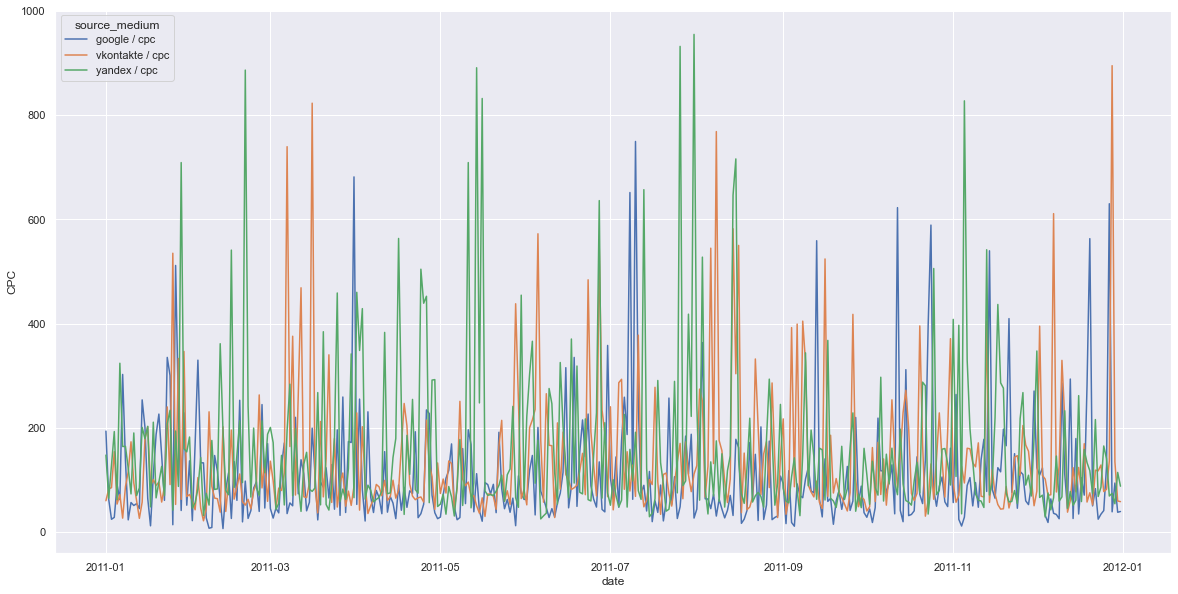

In [28]:
df12.to_excel("cpc_by_day.xlsx") 

plt.figure(figsize = (20, 10))
sns.lineplot(x=df12.date, y=df12.CPC, hue=df12.source_medium);

In [29]:
dftest = df12.copy()
dftest['month'] = dftest.date.dt.month
dftest = dftest.groupby(['month', 'source_medium'], as_index=False).agg({"clicks":'sum', 'cost':'sum'})
dftest           
dftest['CPC'] = dftest.cost / dftest.clicks

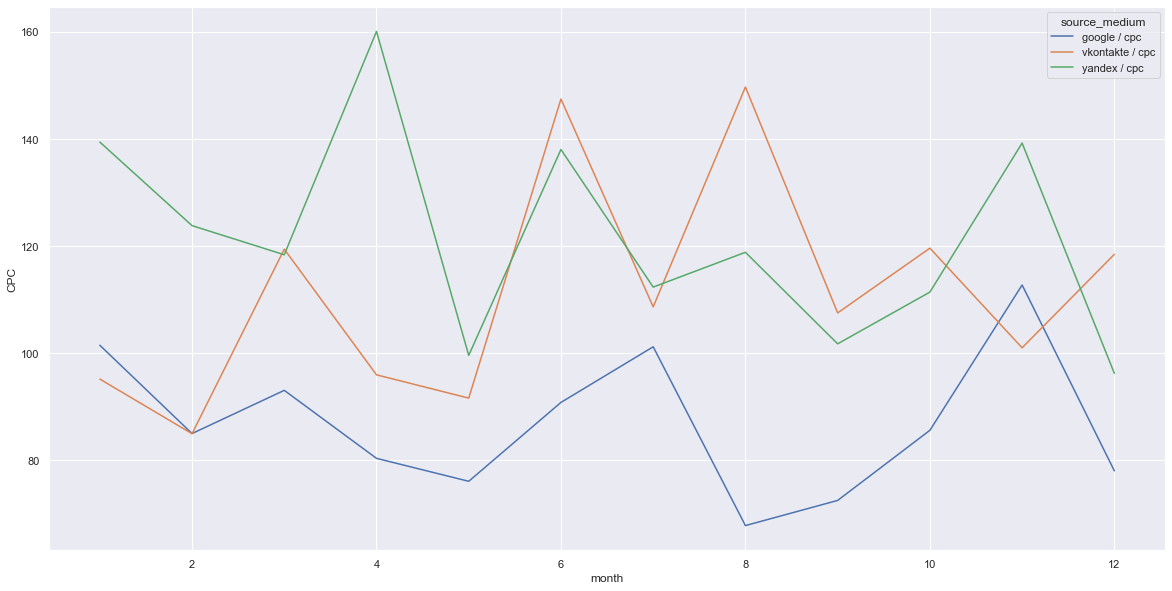

In [30]:
plt.figure(figsize = (20, 10))
sns.lineplot(x=dftest.month, y=dftest.CPC, hue=dftest.source_medium);

#### 13) Рассчитайте средний ROI по месяцам для каждой из рекламных систем

In [31]:
#Воспользуемся уже полученными таблицами
df10.head()

,month,source_medium,sessions,transaction,CR,cost,CPO
0,1,google / cpc,165,43.0,0.260606,16750,389.534884
1,1,vkontakte / cpc,184,67.0,0.364130,17516,261.432836
2,1,yandex / cpc,180,50.0,0.277778,25099,501.980000
3,2,google / cpc,166,50.0,0.301205,14114,282.280000
4,2,vkontakte / cpc,200,67.0,0.335000,16999,253.716418


In [32]:
df11.head()

,client_id,sessiondate,order_id,transaction,source_medium,campaign,profit
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117.0,1.0,direct,NaN,-128.89
1,00039fbdd03f38f626f9b1762e10b31a,2011-06-10,43874.0,1.0,google / cpc,not_brand,-161.21
2,00039fbdd03f38f626f9b1762e10b31a,2011-10-11,9926.0,1.0,yandex / organic,NaN,-56.97
3,00a7fb7251c04c8f17593a3c7a779d82,2011-08-28,6336.0,1.0,google / organic,NaN,-84.13
4,00a7fb7251c04c8f17593a3c7a779d82,2011-09-26,19075.0,1.0,direct,NaN,12.95


In [33]:
df11['month'] = df11.sessiondate.dt.month
df13 = df11.query('source_medium.str.contains(" / cp")', engine='python')\
        .groupby(['month','source_medium'], as_index=False).agg({'profit':'sum'})

df13 = pd.merge(df13, df10, on= ['month','source_medium'])
df13['ROI'] = 100* round((df13.profit - df13.cost) / df13.cost, 4)
df13.head()

,month,source_medium,profit,sessions,transaction,CR,cost,CPO,ROI
0,1,google / cpc,21286.76,165,43.0,0.260606,16750,389.534884,27.09
1,1,vkontakte / cpc,32363.56,184,67.0,0.364130,17516,261.432836,84.77
2,1,yandex / cpc,20896.85,180,50.0,0.277778,25099,501.980000,-16.74
3,2,google / cpc,-3421.91,166,50.0,0.301205,14114,282.280000,-124.24
4,2,vkontakte / cpc,25234.16,200,67.0,0.335000,16999,253.716418,48.44


In [34]:
pivtbl13 = df13.pivot_table(index='month', columns='source_medium', values='ROI')
pivtbl13

source_medium,google / cpc,vkontakte / cpc,yandex / cpc
month,,,
1,27.09,84.77,-16.74
2,-124.24,48.44,-89.47
3,31.15,-26.41,39.33
4,54.25,-42.89,-53.93
5,66.97,-16.67,-31.09
6,-48.32,40.88,-39.48
7,-76.61,71.32,-114.94
8,-42.81,-75.87,-80.35
9,246.55,-59.77,3.51


In [68]:
#ROI за год
temp4 = df13.groupby('source_medium').agg({'cost':'sum', 'profit':'sum'})

temp4['ROI'] = 100* round((temp4.profit - temp4.cost) / temp4.cost, 4)

In [69]:
temp4

,cost,profit,ROI
source_medium,,,
google / cpc,190994,207763.19,8.78
vkontakte / cpc,235961,232428.86,-1.50
yandex / cpc,264115,157703.13,-40.29


#### 14) Рассчитайте средний ДРР для каждого типа рекламных кампаний по кварталам


In [94]:
df11['quarter'] = df11.sessiondate.dt.quarter
df14 = df11.query('source_medium.str.contains(" / cp")', engine='python')\
        .groupby(['quarter','campaign'], as_index=False).agg({'profit':'sum'})
df14

,quarter,campaign,profit
0,1,brand,128149.98
1,1,not_brand,39967.70
2,2,brand,55818.37
3,2,not_brand,94724.83
4,3,brand,65424.92
5,3,not_brand,67590.17
6,4,brand,50084.01
7,4,not_brand,96135.20


In [95]:
costs['quarter'] = costs.date.dt.quarter
costs14 = costs.groupby(['quarter', 'campaign'], as_index=False).agg({'cost':'sum'})

df14 = pd.merge(df14, costs14, on= ['quarter','campaign'])
df14['ДДР'] = 100* round(df14.cost/df14.profit, 4)

pivtbl14 = df14.pivot_table(index='quarter', columns='campaign', values='ДДР')
pivtbl14

campaign,brand,not_brand
quarter,,
1,67.48,216.29
2,157.58,85.73
3,138.48,121.13
4,181.32,89.14


#### 15) Постройте диаграмму, которая отображает распределение регионов заказов и рекламных систем, привлекших эти заказы

In [37]:
crm15 = crm.groupby(['order_id']).agg({'region':'max'})
df15 = pd.merge(sessions.query('order_id==order_id'), crm15, on='order_id')
df15 = df15.query('source_medium.str.contains(" / cp")', engine='python')
df15.head()

,client_id,sessiondate,order_id,transaction,source_medium,campaign,region
1,00039fbdd03f38f626f9b1762e10b31a,2011-06-10,43874.0,1.0,google / cpc,not_brand,Leningrad Obl
5,00a7fb7251c04c8f17593a3c7a779d82,2011-11-16,22404.0,1.0,google / cpc,not_brand,Leningrad Obl
9,00f9b72300bf715dc97f0b32f3854f25,2011-08-01,610.0,1.0,vkontakte / cpc,not_brand,Leningrad Obl
15,014d7b692d2d5ea2de19be3f0da2fabc,2011-08-01,13988.0,1.0,google / cpc,brand,Leningrad Obl
25,01a9621046642a9d7cbfeb3c78c0ddf7,2011-01-25,7043.0,1.0,google / cpc,not_brand,Saint-Petersburg


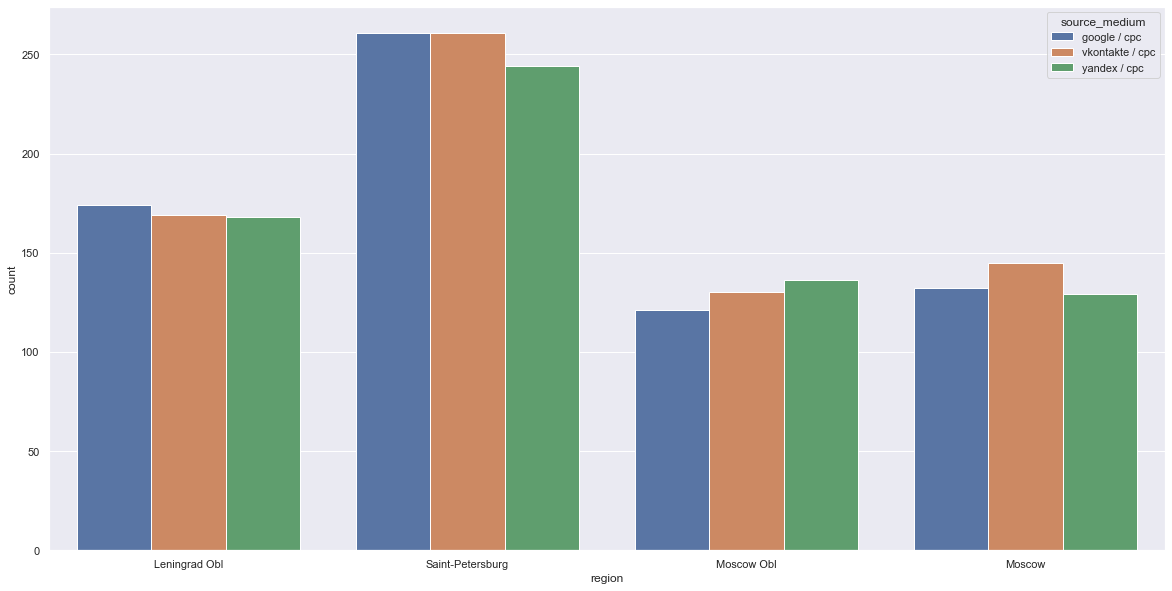

In [38]:
df15.to_excel("orders_by_region.xlsx") 

plt.figure(figsize = (20, 10))
sns.countplot(x=df15.region, hue=df15.source_medium);

## Атрибуция

In [39]:
attr = sessions.copy().sort_values(['client_id','sessiondate'])

In [40]:
#проверка наличия цепочек, не заканчивающихся транзакцией
k=0
for i in range(0, len(attr.index)-1):
    if attr.client_id.values[i] != attr.client_id.values[i+1] and attr.transaction.values[i] == 0:
        k+=1
print(k)

941


In [41]:
#поиск индексов строк для таких цепочек и удаление их
ind = []
for i in range(2, len(attr.index)):
    
    if attr.client_id.values[len(attr.index)-i] != attr.client_id.values[len(attr.index)-i+1] \
    and attr.transaction.values[len(attr.index)-i] == 0:
        
        ind.append(len(attr.index)-i)
        
        for j in range(1, len(attr.index)-1):
            
            if attr.client_id.values[len(attr.index)-i] == attr.client_id.values[len(attr.index)-i-j] \
            and attr.transaction.values[len(attr.index)-i-j] == 0:
                
                ind.append(len(attr.index)-i-j)
            else:
                break
attr = attr.drop(ind, axis=0).reset_index(drop=True)

In [42]:
#проверка еще раз наличия цепочек, не заканчивающихся транзакцией
k=0
for i in range(0, len(attr.index)-1):
    if attr.client_id.values[i]!=attr.client_id.values[i+1] and attr.transaction.values[i]==0:
        k+=1
print(k)

0


In [85]:
#посмотрим заодно показатель ассоциированных конверсий
print('yandex: {}'.format(round(attr.query('source_medium=="yandex / cpc" and transaction ==0').shape[0]
                                /attr.query('source_medium=="yandex / cpc" and transaction !=0').shape[0], 2)))
print('google: {}'.format(round(attr.query('source_medium=="google / cpc" and transaction ==0').shape[0]
                                /attr.query('source_medium=="google / cpc" and transaction !=0').shape[0], 2)))
print('vkontakte: {}'.format(round(attr.query('source_medium=="vkontakte / cpc" and transaction ==0').shape[0]
                                   /attr.query('source_medium=="vkontakte / cpc" and transaction !=0').shape[0], 2)))

yandex: 2.14
google: 2.1
vkontakte: 1.93


In [43]:
attr = attr.drop('client_id', axis=1)

In [44]:
#нумерация цепочек конверсий
chain = [attr.transaction.values[0]]

for i in range(1, len(attr.index)):
    if attr.transaction.values[i-1]==1:
        chain.append(chain[i-1]+1)
    else:
        chain.append(chain[i-1])
    
attr['chain']=chain

In [45]:
# последний клик
attr['last']=attr.transaction

In [46]:
# первый клик

first = [1]

for i in range(1, len(attr.index)):
    if attr.chain.values[i]==attr.chain.values[i-1]:
        first.append(0)
    else:
        first.append(1)
    
attr['first']=first


In [47]:
# последний значимый клик
if  attr.source_medium.values[len(attr.index)-1] != 'direct':
    prev = [1]
elif attr.chain.values[len(attr.index)-1]!=attr.chain.values[len(attr.index)-2]:
    prev = [1]
else:
    prev = [0]

for i in range(1, len(attr.index)):
    
            
    if attr.chain.values[len(attr.index)-i-1]!=attr.chain.values[len(attr.index)-i]:
        
        if attr.transaction.values[len(attr.index)-i-1] == 1 and attr.source_medium.values[len(attr.index)-i-1] != 'direct':
            prev.append(1)
        elif attr.transaction.values[len(attr.index)-i-1] == 1 and attr.chain.values[len(attr.index)-i-1]!=attr.chain.values[len(attr.index)-i-2]:
            prev.append(1)
        else:
            prev.append(0)
            
    else:
        if attr.transaction.values[len(attr.index)-i] == 1 and attr.source_medium.values[len(attr.index)-i] == 'direct':
            prev.append(1)
        else:
            prev.append(0)

prev = prev[::-1]
    
attr['previous'] = prev

In [48]:
# линейная (берем среднее по цепочке и присоединяем)

temp1 = attr.groupby('chain', as_index=False).agg({'transaction':'mean'}).rename(columns={'transaction':"linear"})
attr = pd.merge(attr, temp1, how='left', on='chain')

In [50]:
# time decay - нумеруем строки внутри цепочки и суммируем их

attr['rank'] = attr.groupby('chain').cumcount() + 1

temp2 = attr.groupby('chain', as_index=False).agg({'rank':'sum'}).rename(columns={'rank':"sumrank"})
attr = pd.merge(attr, temp2, how='left', on='chain')

attr['time_decay'] = attr['rank']/attr.sumrank

In [49]:
# прибавляем к таблице суммы заказов

attr['order'] = attr['order_id']
order = [attr.order_id.values[len(attr.index)-1]]

for i in range(1, len(attr.index)):
                
    if attr.chain.values[len(attr.index)-i-1]==attr.chain.values[len(attr.index)-i]:
        attr['order'][len(attr.index)-i-1] = attr['order'][len(attr.index)-i]

attr = pd.merge(attr, crm11, how='left', left_on='order', right_on='order_id')

<ipython-input-49-c293038c5c89>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attr['order'][len(attr.index)-i-1] = attr['order'][len(attr.index)-i]


In [59]:
#итого получилось
attr.head(30)

# chain - номер цепочки
# last
# first
# previous
# linear
# time_decay

,sessiondate,order_id,transaction,source_medium,campaign,chain,last,first,previous,linear,order,profit,rank,sumrank,time_decay
0,2011-04-14,NaN,0.0,sendpulse / email,news,0.0,0.0,1,0,0.333333,38117.0,-128.89,1,6,0.166667
1,2011-04-17,NaN,0.0,direct,NaN,0.0,0.0,0,1,0.333333,38117.0,-128.89,2,6,0.333333
2,2011-04-20,38117.0,1.0,direct,NaN,0.0,1.0,0,0,0.333333,38117.0,-128.89,3,6,0.500000
3,2011-06-05,NaN,0.0,mail / organic,NaN,1.0,0.0,1,0,0.333333,43874.0,-161.21,1,6,0.166667
4,2011-06-08,NaN,0.0,yandex / cpc,brand,1.0,0.0,0,0,0.333333,43874.0,-161.21,2,6,0.333333
5,2011-06-10,43874.0,1.0,google / cpc,not_brand,1.0,1.0,0,1,0.333333,43874.0,-161.21,3,6,0.500000
6,2011-10-08,NaN,0.0,direct,NaN,2.0,0.0,1,0,0.500000,9926.0,-56.97,1,3,0.333333
7,2011-10-11,9926.0,1.0,yandex / organic,NaN,2.0,1.0,0,1,0.500000,9926.0,-56.97,2,3,0.666667
8,2011-08-20,NaN,0.0,google / organic,NaN,3.0,0.0,1,0,0.333333,6336.0,-84.13,1,6,0.166667
9,2011-08-25,NaN,0.0,google / cpc,brand,3.0,0.0,0,0,0.333333,6336.0,-84.13,2,6,0.333333


In [52]:
#суммируем транзакции
attr1 = attr.groupby('source_medium', as_index=False)\
        .agg({'last':'sum', 'first':'sum', 'previous':'sum', 'linear':'sum', 'time_decay':'sum'})

In [53]:
attr1.head()

,source_medium,last,first,previous,linear,time_decay
0,direct,437.0,522,66,503.948426,494.944649
1,google / cpc,688.0,522,728,562.001668,581.120890
2,google / organic,858.0,1026,956,1023.259792,999.233510
3,mail / organic,409.0,511,463,508.042625,498.001857
4,sendpulse / email,556.0,519,604,513.455156,519.086688


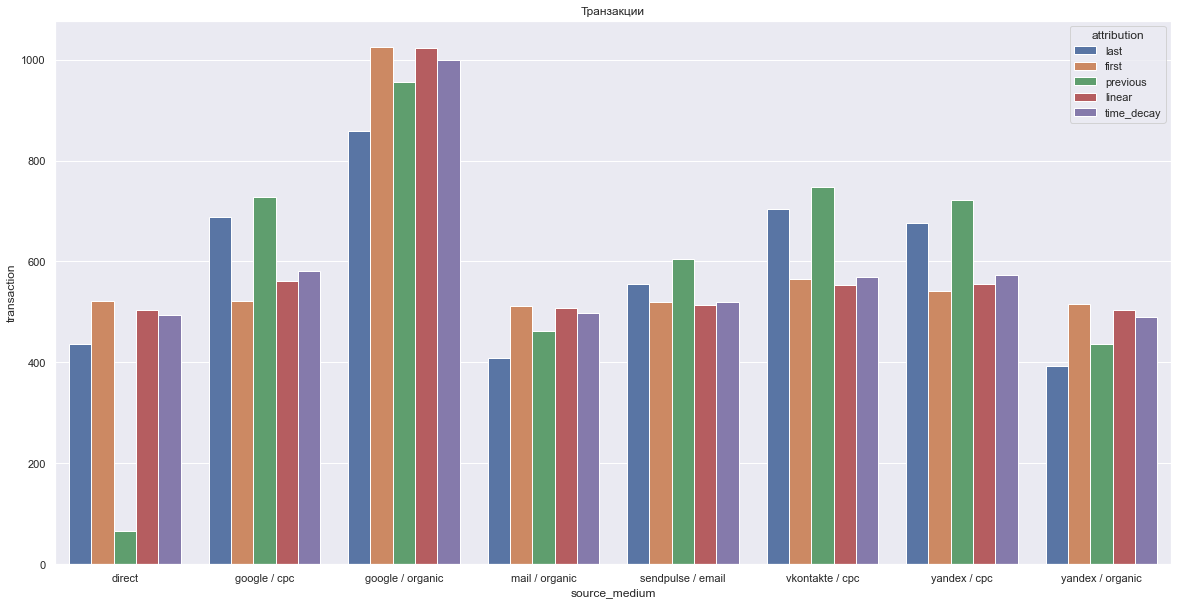

In [54]:
plt.figure(figsize = (20, 10))
attr2 = pd.melt(attr1, id_vars = ['source_medium'], 
        value_vars=['last', 'first', 'previous', 'linear', 'time_decay']) \
        .rename(columns={'variable':'attribution', 'value':'transaction'})

attr2.to_excel("attribution_transactions.xlsx") 

sns.barplot(x='source_medium', y='transaction', data = attr2, hue='attribution');
plt.title('Транзакции');

In [55]:
#посмотрим то же самое для профита

attr_profit = attr.copy()
attr_profit['last'] = attr_profit['last'] * attr_profit.profit
attr_profit['first'] = attr_profit['first'] *attr_profit.profit
attr_profit['previous'] = attr_profit.previous*attr_profit.profit
attr_profit['linear'] = attr_profit.linear*attr_profit.profit
attr_profit['time_decay'] = attr_profit.time_decay*attr_profit.profit

In [56]:
attr3 = attr_profit.groupby('source_medium', as_index=False)\
        .agg({'last':'sum', 'first':'sum', 'previous':'sum', 'linear':'sum', 'time_decay':'sum'})

In [57]:
attr3

,source_medium,last,first,previous,linear,time_decay
0,direct,124350.83,176419.02,35232.09,165366.168101,160933.965290
1,google / cpc,207763.19,132322.89,213338.75,165638.694284,172163.460737
2,google / organic,154224.73,269880.38,176019.80,248849.104855,232801.640988
3,mail / organic,59853.13,134061.65,78292.24,104163.238389,95407.278951
4,sendpulse / email,181468.53,97278.01,194186.75,127793.652549,139514.091202
5,vkontakte / cpc,232428.86,164216.62,236887.60,154254.183916,163556.609628
6,yandex / cpc,157703.13,135527.48,171546.68,139468.232532,142795.826898
7,yandex / organic,117144.63,125230.98,129433.12,129403.755374,127764.156306


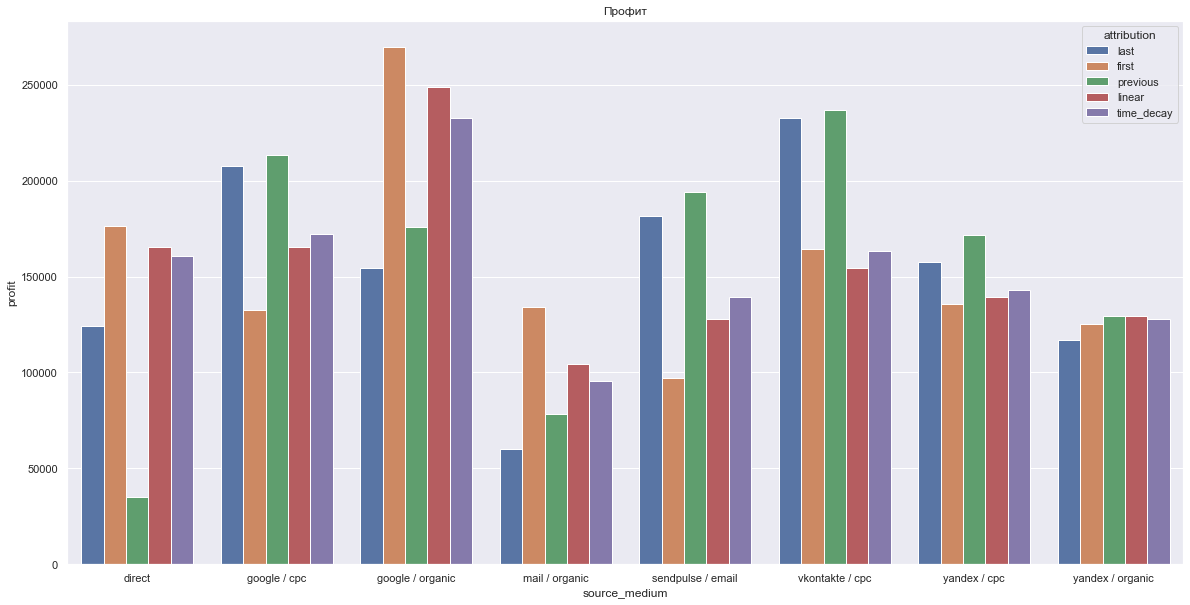

In [58]:
plt.figure(figsize = (20, 10))
attr4 = pd.melt(attr3, id_vars = ['source_medium'], 
        value_vars=['last', 'first', 'previous', 'linear', 'time_decay']) \
        .rename(columns={'variable':'attribution', 'value':'profit'})

attr4.to_excel("attribution_profit.xlsx") 

sns.barplot(x='source_medium', y='profit', data = attr4, hue='attribution');
plt.title('Профит');